## Testing N decoders

## Imports

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
from typing import Optional, Callable, List
from collections import OrderedDict

import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
import torch

import json
import time
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
from torch import nn
from torch.distributions.kl import kl_divergence as kl
from torch.distributions import Normal, Poisson
import torch.nn.functional as F
import DeepDive

In [2]:
import sys
sys.path.insert(0, "../utils")
from utils import preprocess, get_colormap_colors
from downsampled import sample_w_cramer, calc_de
from simulation import compare_groups, get_model_DE, get_DE

# Simulated data

In [3]:
model_params = {
}

train_params = {
    'batch_size' : 512, 
}

In [4]:
discrete_covriate_keys = ['Uppercase', 'Lowercase']

In [5]:
n_cells = 5000
n_features = 5000
covariates = {
    "Uppercase": ["A", "B"],
    "Lowercase": ["a", "b"],
}
steps = np.arange(0.0, 1.05, 0.1)

In [6]:
files = glob.glob(f'output_*.tsv', root_dir = '../data/Simulated_n_decoders')

In [7]:
entanglement = []
indexes = []
n_decoders = []

average_precision_dd_p = []
average_precision_lfc_p = []

runs = []

for f in files:
    print(f)
    _, run, idx, i, d = f.split('.tsv')[0].split('_')
    


    
    i = float(i)
    idx = int(idx)
    run = int(run)
    d = int(d)
    runs.append(run)
    indexes.append(idx)
    entanglement.append(i)
    n_decoders.append(d)
    observed = pd.read_csv('../data/Simulated_n_decoders/'+f, sep = '\t', index_col = 0)
    
    average_precision_dd_p.append(average_precision_score(abs(observed.Eff_up) > 0, -np.log10(observed.Pvalue + 1e-8)))
    average_precision_lfc_p.append(average_precision_score(abs(observed.Eff_up) > 0, -np.log10(observed.A_p + 1e-8)))



output_0_2_0.2_20.tsv
output_2_1_0.1_5.tsv
output_1_1_0.1_1.tsv
output_2_5_0.5_20.tsv
output_1_6_0.6000000000000001_5.tsv
output_2_4_0.4_1.tsv
output_0_9_0.9_5.tsv
output_0_6_0.6000000000000001_5.tsv
output_2_10_1.0_5.tsv
output_1_4_0.4_20.tsv
output_1_3_0.30000000000000004_20.tsv
output_2_5_0.5_1.tsv
output_1_8_0.8_5.tsv
output_1_1_0.1_20.tsv
output_1_5_0.5_5.tsv
output_1_4_0.4_1.tsv
output_2_3_0.30000000000000004_1.tsv
output_2_0_0.0_5.tsv
output_0_6_0.6000000000000001_1.tsv
output_1_5_0.5_1.tsv
output_1_0_0.0_20.tsv
output_0_1_0.1_20.tsv
output_2_8_0.8_20.tsv
output_2_4_0.4_5.tsv
output_0_2_0.2_1.tsv
output_1_4_0.4_5.tsv
output_2_7_0.7000000000000001_20.tsv
output_2_6_0.6000000000000001_1.tsv
output_1_7_0.7000000000000001_5.tsv
output_1_9_0.9_5.tsv
output_1_10_1.0_5.tsv
output_0_6_0.6000000000000001_20.tsv
output_0_1_0.1_1.tsv
output_0_8_0.8_20.tsv
output_0_7_0.7000000000000001_20.tsv
output_0_10_1.0_20.tsv
output_2_2_0.2_5.tsv
output_2_3_0.30000000000000004_20.tsv
output_2_2_0.2_1.

In [8]:
result = pd.concat([pd.Series(x) for x in [indexes, entanglement, runs, n_decoders, average_precision_lfc_p, average_precision_dd_p, ]],axis = 1)
result.columns = ['idx', 'i', 'run', 'n_decoders', 'lfc_p', 'dd_p' ]
result = result.sort_values('idx')

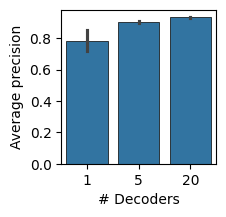

In [9]:
x = result[result.idx == 6]
plt.subplots(figsize=(2,2))
sns.barplot(x, x = 'n_decoders', y = 'dd_p', edgecolor = 'k', linewidth = 0.5
           )
plt.ylabel('Average precision')
plt.xlabel('# Decoders')
plt.savefig('../figures/S4B.pdf')

# Real data

## Setup data

In [10]:
adata = sc.read_h5ad("../data/islet.h5ad")

In [11]:
mapper = {0:'alpha',
1:'beta', 
2:'beta', 
3:'beta', 
4:'alpha', 
5:'beta', 
6:'delta', 
7:'acinar', 
8:'alpha', 
9:'ductal', 
10:'gamma', 
11:'stellate', 
12:'immune', 
13:'endothelial',
}
adata.obs['celltype'] = adata.obs.leiden.map(mapper)

In [12]:
discrete_covriate_keys = ['donor', 'celltype', 'Disease', 'Gender']
continuous_covriate_keys = ['Age', 'HbA1c', 'Purity', 'map_frac', 'BMI']

In [13]:
adata = adata[adata.obs.celltype == 'beta']

In [14]:
adata = preprocess(adata, discrete_covriate_keys, continuous_covriate_keys, frac = 0.1).copy()

In [15]:
data = adata.copy()

## Make baseline with balanced covariates

In [16]:
data_sampled = sample_w_cramer(data, 40000, 0)

In [17]:
data_sampled.write_h5ad('../data/Real_n_decoders/baseline.h5ad')

In [18]:
df_full_sex, df_full_d = calc_de(data_sampled)
df_full_sex = df_full_sex.set_index('M_n')
df_full_d = df_full_d.set_index('T2D_n')

In [19]:
discrete_covriate_keys = ['Gender', 'Disease']


In [20]:
runs = []
entanglement = []
ndec = []
average_precision_lfc = []
average_precision_dd = []

files = glob.glob('output*', root_dir='../data/Real_n_decoders')
for f in files:
    _, run, i, n = f.split('.tsv')[0].split('_')
    try:
        i = float(i)
        n = int(n)
        run = int(run)
    except:
        pass
    
    runs.append(run)
    entanglement.append(i)
    ndec.append(n)
    
    df_entangled_d = pd.read_csv('../data/Real_n_decoders/'+f, sep = '\t', index_col = 0)
    
    df_entangled_d['M_l_full'] = df_full_sex['M_l'][df_entangled_d.index]
    df_entangled_d['M_p_full'] = df_full_sex['M_p'][df_entangled_d.index]
    df_entangled_d['T2D_l_full'] = df_full_d['T2D_l'][df_entangled_d.index]
    df_entangled_d['T2D_p_full'] = df_full_d['T2D_p'][df_entangled_d.index]

    average_precision_lfc.append(average_precision_score(df_entangled_d.M_p_full < 0.05, abs(df_entangled_d.M_l)))
    average_precision_dd.append(average_precision_score(df_entangled_d.M_p_full < 0.05, abs(df_entangled_d.model_M)))


In [21]:
result = pd.concat([pd.Series(x) for x in [entanglement, runs, ndec, 
                                           average_precision_lfc, average_precision_dd]],axis = 1)
result.columns = ['entanglement', 'run', 'ndec', 'lfc', 'dd']

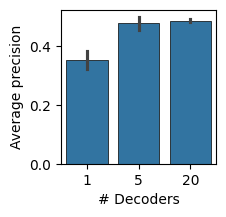

In [22]:
plt.subplots(figsize=(2,2))
sns.barplot(result, x = 'ndec', y = 'dd', edgecolor = 'k', linewidth = 0.5
           )
plt.ylabel('Average precision')
plt.xlabel('# Decoders')
plt.savefig('../figures/S4C.pdf')

## Show the effect of entanglement on selected peaks

In [23]:
test = sc.read_h5ad('../data/Real_n_decoders/downsampled_0_0.6.h5ad')

In [24]:
valid = sc.read_h5ad('../data/Real_n_decoders/baseline.h5ad')

In [25]:
sc.pp.normalize_total(test)
sc.pp.log1p(test)

sc.pp.normalize_total(valid)
sc.pp.log1p(valid)

In [26]:
test_df = test.to_df()
test_df['Sex'] = test.obs.Gender
test_df['Disease'] = test.obs.Disease


valid_df = valid.to_df()
valid_df['Sex'] = valid.obs.Gender
valid_df['Disease'] = valid.obs.Disease

In [27]:
select = '2:129038441-129038941'

In [28]:
test_df['to_plot'] = test_df[select].copy()
valid_df['to_plot'] = valid_df[select].copy()

In [29]:
test_df_plot = test_df[['Sex', 'to_plot']]
test_df_plot2 = test_df[['Disease', 'to_plot']]
valid_df_plot = valid_df[['Sex', 'to_plot']]
valid_df_plot2 = valid_df[['Disease', 'to_plot']]

In [30]:
test_df_plot = test_df_plot[test_df_plot.to_plot != 0]
valid_df_plot = valid_df_plot[valid_df_plot.to_plot != 0]

test_df_plot2 = test_df_plot2[test_df_plot2.to_plot != 0]
valid_df_plot2 = valid_df_plot2[valid_df_plot2.to_plot != 0]

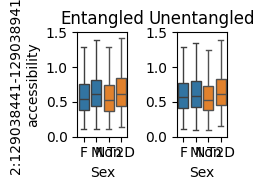

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(2.5,2))
sns.boxplot(test_df_plot, x = 'Sex', y = 'to_plot', fliersize = 0, ax = ax[0])
sns.boxplot(test_df_plot2, x = 'Disease', y = 'to_plot', fliersize = 0, ax = ax[0])
sns.boxplot(valid_df_plot, x = 'Sex', y = 'to_plot', fliersize = False, ax = ax[1])
sns.boxplot(valid_df_plot2, x = 'Disease', y = 'to_plot', fliersize = False, ax = ax[1])

ax[0].set_ylim(0, 1.5)
ax[1].set_ylim(0, 1.5)

ax[0].set_title('Entangled')
ax[1].set_title('Unentangled')

ax[0].set_ylabel(f'{select} \naccessibility')
ax[1].set_ylabel('')

plt.tight_layout()
plt.savefig('../figures/S4F.pdf')
